In [1]:

def khatrirao(matrices, reverse=False):
    # Compute the Khatri-Rao product of all matrices in list "matrices".
    # If reverse is true, does the product in reverse order.
    matorder = range(len(matrices)) if not reverse else list(reversed(range(len(matrices))))
    
    # Error checking on matrices; compute number of rows in result.
    # N = number of columns (must be same for each input)
    N = matrices[0].shape[1] 
    # Compute number of rows in resulting matrix
    # After the loop, M = number of rows in result.
    M = 1
    for i in matorder:
        if matrices[i].ndim != 2:
            raise ValueError("Each argument must be a matrix.")
        if N != (matrices[i].shape)[1]:
            raise ValueError("All matrices must have the same number of columns.")
        M *= (matrices[i].shape)[0]
        
    # Computation
    # Preallocate result.
    P = NP.zeros((M, N))
    
    # n loops over all column indices
    for n in range(N):
        # ab = nth col of first matrix to consider
        ab = matrices[matorder[0]][:,n]
        # loop through matrices
        for i in matorder[1:]:
            # Compute outer product of nth columns
            ab = NP.outer(matrices[i][:,n], ab[:])
        # Fill nth column of P with flattened result
        P[:,n] = ab.flatten()
    return P


def im2double(im):
    info = NP.iinfo(im.dtype) # Get the data type of the input image
    return im.astype(NP.float) / info.max 



In [2]:
def __get_unfolding_mode_order(A, n):
    return [i for i in xrange(n+1, A.ndim)] + [i for i in xrange(n)]
def __get_unfolding_stride(A, mode_order):
    stride = [0 for i in xrange(A.ndim)]
    stride[mode_order[A.ndim-2]] = 1
    for i in xrange(A.ndim-3, -1, -1):
        stride[mode_order[i]] = (
            A.shape[mode_order[i+1]] * stride[mode_order[i+1]])
    return stride
def __get_tensor_indices(r, c, A, n, mode_order, stride):
    i = [0 for j in xrange(A.ndim)]
    i[n] = r
    i[mode_order[0]] = c / stride[mode_order[0]]
    for k in xrange(1, A.ndim-1):
        i[mode_order[k]] = (
            (c % stride[mode_order[k-1]]) / stride[mode_order[k]])
    return i
def get_unfolding_matrix_size(A, n):
    row_count = A.shape[n]    
    col_count = 1   
    for i in xrange(A.ndim):
        if i != n: col_count *= A.shape[i]        
    return (row_count, col_count)
def unfold(A, n):
    """
    Unfold tensor A along Mode n
    """
    (row_count, col_count) = get_unfolding_matrix_size(A, n)
    result = NP.zeros((row_count, col_count))
     
    mode_order = __get_unfolding_mode_order(A, n)
    stride = __get_unfolding_stride(A, mode_order)
         
    for r in xrange(row_count):        
        for c in xrange(col_count):
            i = __get_tensor_indices(r, c, A, n, mode_order, stride)            
            result[r, c] = A.__getitem__(tuple(i))
 
    return result

In [623]:
#"""
# Tensor Completion using IBP Factorization on matrix slice
#"""
import sys
import cPickle as CP

import numpy as NP
import scipy.io as SPIO

from PyIBP import PyIBP as IBP

# IBP parameter (gamma hyperparameters)
(alpha, alpha_a, alpha_b) = (1., 1., 1.)
# Observed data Gaussian noise (Gamma hyperparameters)
(sigma_x, sx_a, sx_b) = (1., 1., 1.)
# Latent feature weight Gaussian noise (Gamma hyperparameters)
(sigma_a, sa_a, sa_b) = (1., 1., 1.)

# Data
from scipy import misc
will = misc.imread("Will-Smith.jpg")
data = will
sample = NP.random.choice([True, False],  data[:,:,0].shape,p=[0.3,0.7])
miss = sample.astype(int)

datar = data[:,:,0]
datag = data[:,:,1]
datab = data[:,:,2]

rfill = NP.zeros(datar.shape)
gfill = NP.zeros(datag.shape)
bfill = NP.zeros(datab.shape)


# IBP parameter (gamma hyperparameters)
(alpha, alpha_a, alpha_b) = (1., 1., 1.)
# Observed data Gaussian noise (Gamma hyperparameters)
(sigma_x, sx_a, sx_b) = (1., 1., 1.)
# Latent feature weight Gaussian noise (Gamma hyperparameters)
(sigma_a, sa_a, sa_b) = (1., 1., 1.)

# Number of full sampling sweeps
numsamp = 10
burn_in = 0

# Center the data
rcdata = IBP.centerData(datar)
gcdata = IBP.centerData(datag)
bcdata = IBP.centerData(datab)


# Initialize the model
r = IBP(rcdata,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=miss)
g = IBP(gcdata,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=miss)
b = IBP(bcdata,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=miss)


# Do inference
for s in range(numsamp):
    # Print current chain state
    r.sampleReport(s)
    r.fullSample()
    g.fullSample()
    b.fullSample()
    if s > burn_in:
        rfill[sample] = rfill[sample] + r.X[sample]
        gfill[sample] = gfill[sample] + g.X[sample]
        bfill[sample] = bfill[sample] + b.X[sample]



iter 0
	K = 7
	alpha = 1.000000
	sigma_x = 1.000000
	sigma_a = 1.000000
iter 1
	K = 9
	alpha = 3.156992
	sigma_x = 30.428098
	sigma_a = 34.373011
iter 2
	K = 9
	alpha = 3.499579
	sigma_x = 31.672979
	sigma_a = 38.098693
iter 3
	K = 9
	alpha = 3.629170
	sigma_x = 31.708650
	sigma_a = 39.072855
iter 4
	K = 10
	alpha = 3.292611
	sigma_x = 31.576179
	sigma_a = 40.377432
iter 5
	K = 10
	alpha = 3.430228
	sigma_x = 31.324730
	sigma_a = 38.672703
iter 6
	K = 10
	alpha = 3.517686
	sigma_x = 30.822619
	sigma_a = 41.034861
iter 7
	K = 10
	alpha = 3.516375
	sigma_x = 30.701297
	sigma_a = 40.152455
iter 8
	K = 11
	alpha = 3.518632
	sigma_x = 30.424367
	sigma_a = 41.442561
iter 9
	K = 12
	alpha = 3.730738
	sigma_x = 29.580283
	sigma_a = 39.417863


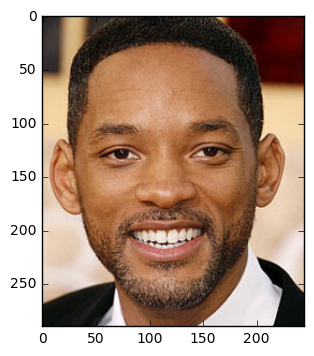

In [256]:
import matplotlib.pyplot as plt
# Real Image
plt.imshow(data)
plt.show()

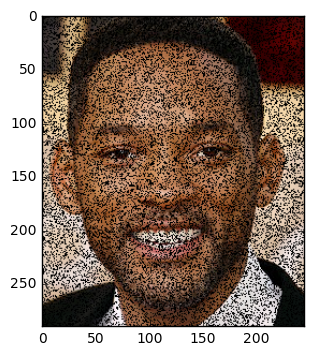

In [257]:
# Incomplete Image
nandata = NP.copy(will)
nandata[:,:,0][sample] = 0
nandata[:,:,1][sample] = 0
nandata[:,:,2][sample] = 0
plt.imshow(nandata)
plt.show()

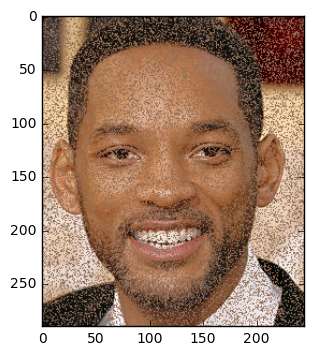

0.0795916247257
0.071017657129
0.0632559173235


In [367]:
# Mean Substitution
olddata = im2double(data)
meandata = im2double(data)
rmean=NP.mean(meandata[:,:,0])
gmean=NP.mean(meandata[:,:,1])
bmean=NP.mean(meandata[:,:,2])
meandata[:,:,0][sample] = rmean
meandata[:,:,1][sample] = gmean
meandata[:,:,2][sample] = bmean
plt.imshow(meandata)
plt.show()
print(NP.mean((olddata[:,:,0][sample]-rmean)**2))
print(NP.mean((olddata[:,:,1][sample]-gmean)**2))
print(NP.mean((olddata[:,:,2][sample]-bmean)**2))

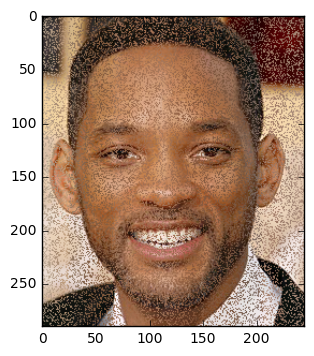

0.0741894875266
0.0648241404733
0.0563772834914


In [369]:
# Column Mean Substitution
meandata = im2double(data)
olddata = im2double(data)
for i in range(will.shape[1]):
    rmean=NP.mean(meandata[:,i,0])
    gmean=NP.mean(meandata[:,i,1])
    bmean=NP.mean(meandata[:,i,2])
    meandata[:,i,0][sample[:,i]] = rmean
    meandata[:,i,1][sample[:,i]] = gmean
    meandata[:,i,2][sample[:,i]] = bmean
plt.imshow(meandata)
plt.show()
print(NP.mean((olddata[:,:,0][sample]-meandata[:,:,0][sample])**2))
print(NP.mean((olddata[:,:,1][sample]-meandata[:,:,1][sample])**2))
print(NP.mean((olddata[:,:,2][sample]-meandata[:,:,2][sample])**2))

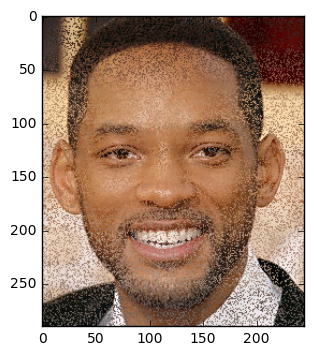

0.054903312897
0.0541459485192
0.0513219861633


In [370]:
# Row Mean Substitution
meandata = im2double(data)
olddata = im2double(data)
for i in range(will.shape[0]):
    rmean=NP.mean(meandata[i,:,0])
    gmean=NP.mean(meandata[i,:,1])
    bmean=NP.mean(meandata[i,:,2])
    meandata[i,:,0][sample[i,:]] = rmean
    meandata[i,:,1][sample[i,:]] = gmean
    meandata[i,:,2][sample[i,:]] = bmean
plt.imshow(meandata)
plt.show()
print(NP.mean((olddata[:,:,0][sample]-meandata[:,:,0][sample])**2))
print(NP.mean((olddata[:,:,1][sample]-meandata[:,:,1][sample])**2))
print(NP.mean((olddata[:,:,2][sample]-meandata[:,:,2][sample])**2))

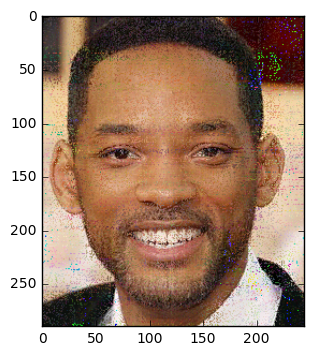

0.0215658411627
0.0234552020738
0.0290157201997


In [625]:
# Completed Image
completed = NP.copy(data)
olddata = im2double(data)
completed[:,:,0][sample] = r.featMeans(datar)[sample] + rfill[sample]/(numsamp - burn_in) 
completed[:,:,1][sample] = g.featMeans(datag)[sample] + gfill[sample]/(numsamp - burn_in) 
completed[:,:,2][sample] = b.featMeans(datab)[sample] + bfill[sample]/(numsamp - burn_in) 
completed = im2double(completed)
plt.imshow(completed)
plt.show()
print(NP.mean((olddata[:,:,0][sample]-completed[:,:,0][sample])**2))
print(NP.mean((olddata[:,:,1][sample]-completed[:,:,1][sample])**2))
print(NP.mean((olddata[:,:,2][sample]-completed[:,:,2][sample])**2))

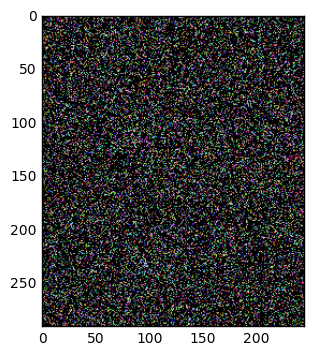

In [626]:
# The fill-ins seem random when stacked... But separated yield approximations to the image
completed = NP.zeros(data.shape)
completed[:,:,0][sample] = r.featMeans(datar)[sample] + rfill[sample]/(numsamp - burn_in) 
completed[:,:,1][sample] = g.featMeans(datag)[sample] + gfill[sample]/(numsamp - burn_in) 
completed[:,:,2][sample] = b.featMeans(datab)[sample] + bfill[sample]/(numsamp - burn_in) 
plt.imshow(completed)
plt.show()

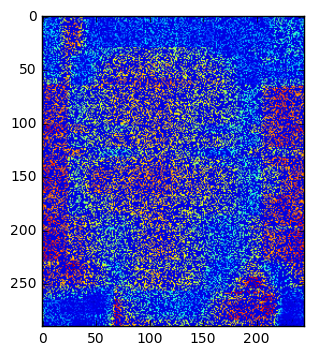

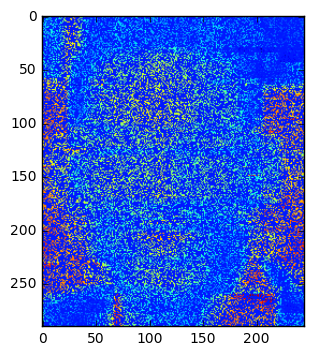

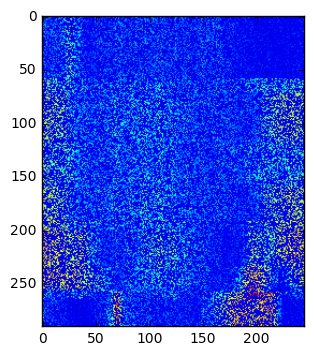

In [375]:
# The fillins seem random when stacked... But separated yield approximations to the image
completed = NP.zeros(data.shape)
completed[:,:,0][sample] = r.featMeans(datar)[sample] + rfill[sample]/(numsamp - burn_in) 
completed[:,:,1][sample] = g.featMeans(datag)[sample] + gfill[sample]/(numsamp - burn_in) 
completed[:,:,2][sample] = b.featMeans(datab)[sample] + bfill[sample]/(numsamp - burn_in) 
plt.imshow(completed[:,:,0])
plt.show()
plt.imshow(completed[:,:,1])
plt.show()
plt.imshow(completed[:,:,2])
plt.show()

In [629]:
import sktensor as t
import sys
import cPickle as CP

import numpy as NP
import scipy.io as SPIO

from PyIBP import PyIBP as IBP

will = misc.imread("Will-Smith.jpg")
data = will
sample = NP.random.choice([True, False],  data[:,:,1].shape,p=[0.3,0.7])
miss = sample.astype(int)

tensorsample = NP.zeros(data.shape)
for i in range(data.shape[2]):
    tensorsample[:,:,i] = sample
    
T = t.dtensor(data)
F = t.dtensor(will)
S = t.dtensor(tensorsample)

X1miss = S.unfold(0).astype(bool)
X2miss = S.unfold(1).astype(bool)
X3miss = S.unfold(2).astype(bool)

X1dat = T.unfold(0)
X2dat = T.unfold(1)
X3dat = T.unfold(2)

X1fill = NP.zeros(X1dat.shape)
X2fill = NP.zeros(X2dat.shape)
X3fill = NP.zeros(X3dat.shape)

# Number of full sampling sweeps
numsamp = 5
burn_in = 0

X1cdat = IBP.centerData(X1dat)
X2cdat = IBP.centerData(X2dat)
X3cdat = IBP.centerData(X3dat)

# Initialize the model
X1 = IBP(X1cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X1miss.astype(int))
X2 = IBP(X2cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X2miss.astype(int))
X3 = IBP(X3cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X3miss.astype(int))


# Do inference
for s in range(numsamp):
# Print current chain state
    X3.sampleReport(s)
    X1.fullSample()
    X2.fullSample()
    X3.fullSample()
    if s > burn_in:
        X1fill[X1miss] = X1fill[X1miss] + X1.X[X1miss]
        X2fill[X2miss] = X2fill[X2miss] + X2.X[X2miss]
        X3fill[X3miss] = X3fill[X3miss] + X3.X[X3miss]



iter 0
	K = 3
	alpha = 1.000000
	sigma_x = 1.000000
	sigma_a = 1.000000
iter 1
	K = 3
	alpha = 0.981281
	sigma_x = 11.459845
	sigma_a = 11.984643
iter 2
	K = 3
	alpha = 0.633610
	sigma_x = 13.902325
	sigma_a = 16.100536
iter 3
	K = 3
	alpha = 1.355417
	sigma_x = 14.533742
	sigma_a = 19.102948
iter 4
	K = 3
	alpha = 0.839681
	sigma_x = 14.336462
	sigma_a = 21.537267


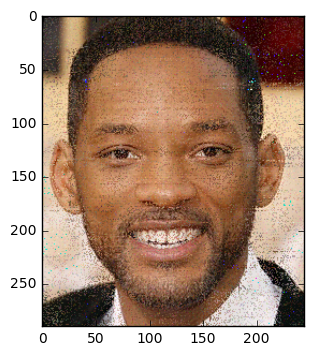

0.0251715247058
0.0818262689288
(213150, 51250)


In [543]:
# Completed X1 Matrix
NewX1 = T.unfold(0)
OldX1 = im2double(X1dat)
NewX1[X1miss] = X1.featMeans(X1dat)[X1miss] + X1fill[X1miss]/(numsamp - burn_in)
NewX1 = im2double(NewX1)
plt.imshow(NewX1.fold())
plt.show()
mean = NP.mean(NewX1)
print(NP.mean((OldX1[X1miss]-NewX1[X1miss])**2))
print(NP.mean((OldX1[X1miss]-mean)**2))
print((X1.X.size, (numsamp-burn_in)*(X1.ZV.size + X1.weights().size)))

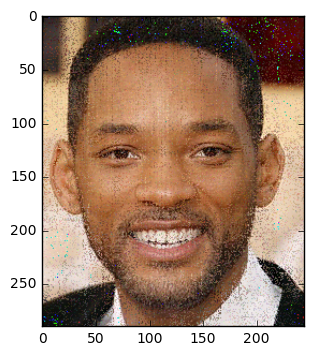

0.025324584716
0.0818286065765
(213150, 55750)


In [542]:
# Completed X2 Matrix
NewX2 = T.unfold(1)
OldX2 = im2double(X2dat)
NewX2[X2miss] = X2.featMeans(X2dat)[X2miss] + X2fill[X2miss]/(numsamp - burn_in) 
NewX2= im2double(NewX2)
mean = NP.mean(NewX2)
plt.imshow(NewX2.fold())
plt.show()
print(NP.mean((OldX2[X2miss]-NewX2[X2miss])**2))
print(NP.mean((OldX2[X2miss]-mean)**2))
print((X2.X.size, (numsamp-burn_in)*(X2.ZV.size + X2.weights().size)))

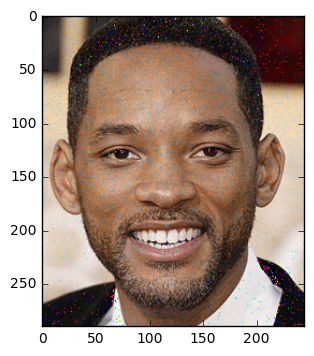

0.0233912383061
0.0818339967485
(213150, 1065795)


In [541]:
# Completed X3 Matrix
NewX3 = T.unfold(2)
OldX3 = im2double(X3dat)
NewX3[X3miss] = X3.featMeans(X3dat)[X3miss] + X3fill[X3miss]/(numsamp - burn_in) 
NewX3= im2double(NewX3)
mean = NP.mean(NewX3)
plt.imshow(NewX3.fold())
plt.show()
print(NP.mean((OldX3[X3miss]-NewX3[X3miss])**2))
print(NP.mean((OldX3[X3miss]-mean)**2))
print((X3.X.size, (numsamp-burn_in)*(X3.ZV.size + X3.weights().size)))

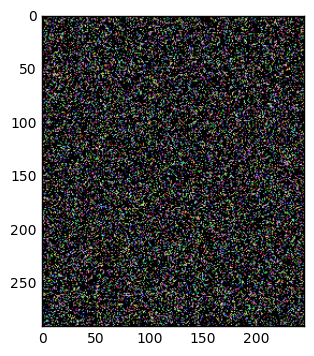

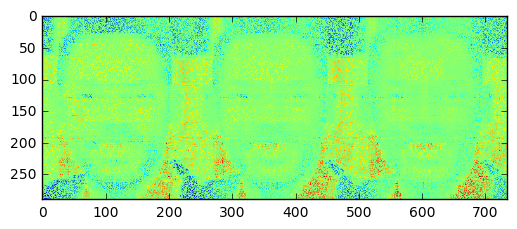

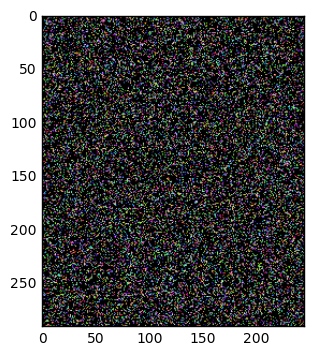

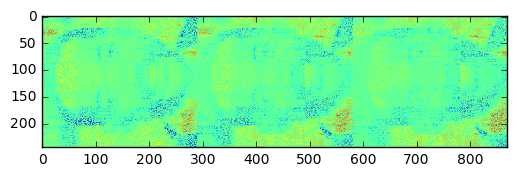

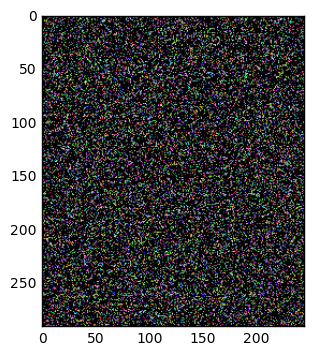

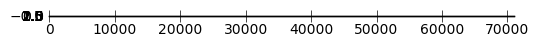

In [627]:
ZT = t.dtensor(NP.zeros(data.shape))

NewX1 = ZT.unfold(0)
NewX2 = ZT.unfold(1)
NewX3 = ZT.unfold(2)

NewX1[X1miss] = X1fill[X1miss]/(numsamp - burn_in) 
NewX2[X2miss] = X2fill[X2miss]/(numsamp - burn_in) 
NewX3[X3miss] = X3fill[X3miss]/(numsamp - burn_in)

plt.imshow(NewX1.fold())
plt.show()
plt.imshow(NewX1)
plt.show()
plt.imshow(NewX2.fold())
plt.show()
plt.imshow(NewX2)
plt.show()
plt.imshow(NewX3.fold())
plt.show()
plt.imshow(NewX3)
plt.show()

In [924]:
N = 5
I = 30
J = 30
K = 40
A = NP.random.randint(-2,3,(30,5))
B = NP.random.randint(-2,3,(30,5))
C = NP.random.randint(-2,3,(40,5))

F = NP.zeros((30,30,40))
for n in range(N):
        for i in range(30):
                for j in range(30):
                    for k in range(40):
                        F[i,j,k] = F[i,j,k] + A[i,n]*B[j,n]*C[k,n] + NP.random.normal(0,5)

In [926]:
F

array([[[  4.01013909e-01,  -7.20134672e+00,  -1.06489516e+01, ...,
           1.81843369e+01,  -1.42354691e+01,   2.60387713e+00],
        [  7.56990962e+00,   6.40763536e+00,  -9.30400548e+00, ...,
          -4.63757799e+00,  -6.79836895e+00,   7.86230648e+00],
        [  1.49588139e+01,  -4.34312074e+00,  -1.53103359e+01, ...,
          -1.39315255e+01,  -2.11261636e+01,  -1.07339148e+01],
        ..., 
        [  7.51300991e+00,  -8.37664370e+00,   1.20525415e+01, ...,
          -5.21702364e-02,   1.38249472e+01,  -1.06679519e+01],
        [ -3.84302702e+00,  -1.76418719e+01,   7.18481198e+00, ...,
           1.70012281e+01,   9.01384737e+00,  -5.65370185e+00],
        [  5.84983345e+00,   8.23966470e+00,  -4.63688909e-02, ...,
           9.09586414e+00,  -2.54914997e+01,   3.54612495e-01]],

       [[ -7.83998477e-01,  -2.80521450e+00,  -1.57573939e+01, ...,
          -1.53802384e+01,  -5.30436309e+00,   6.80142470e+00],
        [ -4.36069615e-01,   1.10644746e+01,  -9.79796813e+0

In [927]:
data = F
sample = NP.random.choice([True, False],  data.shape,p=[0.3,0.7])

T = t.dtensor(data)
S = t.dtensor(sample)

X1miss = S.unfold(0).astype(bool)
X2miss = S.unfold(1).astype(bool)
X3miss = S.unfold(2).astype(bool)

X1dat = T.unfold(0)
X2dat = T.unfold(1)
X3dat = T.unfold(2)


In [816]:
X1dat

unfolded_dtensor([[ 0.08470773,  1.67397026,  0.34474655, -0.51888239,  0.94541287,
        -0.54733502,  0.08712767, -0.48809441, -0.49586082, -0.14412793,
         0.12749559, -0.23855358],
       [ 1.94570608, -1.51992744, -2.88995358, -0.04152897, -3.08628419,
        -0.99682346,  0.46097231,  0.66999603, -0.59539412, -0.0443971 ,
        -0.53733751,  1.10323664],
       [ 0.45916679,  4.11476336,  0.6881071 ,  0.32943574, -0.90691947,
        -0.59736265, -1.23989911,  0.31972486, -2.32229263, -0.13965861,
         0.39582585,  0.97741102]])

In [929]:

X1fill = NP.zeros(X1dat.shape)
X2fill = NP.zeros(X2dat.shape)
X3fill = NP.zeros(X3dat.shape)

# Number of full sampling sweeps
numsamp = 20
burn_in = 10

X1cdat = IBP.centerData(X1dat)
X2cdat = IBP.centerData(X2dat)
X3cdat = IBP.centerData(X3dat)

# Initialize the model
X1 = IBP(X1cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X1miss.astype(int))
X2 = IBP(X2cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X2miss.astype(int))
X3 = IBP(X3cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X3miss.astype(int))


# Do inference
for s in range(numsamp):
# Print current chain state
    X3.sampleReport(s)
    X1.fullSample()
    X2.fullSample()
    X3.fullSample()
    if s > burn_in:
        X1fill[X1miss] = X1fill[X1miss] + X1.X[X1miss]
        X2fill[X2miss] = X2fill[X2miss] + X2.X[X2miss]
        X3fill[X3miss] = X3fill[X3miss] + X3.X[X3miss]



iter 0
	K = 9
	alpha = 1.000000
	sigma_x = 1.000000
	sigma_a = 1.000000
iter 1
	K = 9
	alpha = 4.481718
	sigma_x = 8.185432
	sigma_a = 4.619539
iter 2
	K = 9
	alpha = 3.869073
	sigma_x = 9.874804
	sigma_a = 4.467455
iter 3
	K = 11
	alpha = 3.392426
	sigma_x = 10.605344
	sigma_a = 4.326841
iter 4
	K = 12
	alpha = 3.354637
	sigma_x = 11.025900
	sigma_a = 4.160394
iter 5
	K = 12
	alpha = 3.176912
	sigma_x = 11.121469
	sigma_a = 3.998897
iter 6
	K = 12
	alpha = 3.283719
	sigma_x = 11.201731
	sigma_a = 3.899572
iter 7
	K = 14
	alpha = 3.741180
	sigma_x = 11.229899
	sigma_a = 3.862403
iter 8
	K = 14
	alpha = 3.873703
	sigma_x = 11.279170
	sigma_a = 3.796513
iter 9
	K = 14
	alpha = 3.881975
	sigma_x = 11.207448
	sigma_a = 3.714422
iter 10
	K = 16
	alpha = 3.724116
	sigma_x = 11.201561
	sigma_a = 3.639350
iter 11
	K = 15
	alpha = 3.132417
	sigma_x = 11.118817
	sigma_a = 3.579426
iter 12
	K = 17
	alpha = 3.467972
	sigma_x = 11.255302
	sigma_a = 3.550348
iter 13
	K = 16
	alpha = 3.112934
	sigma_

In [930]:
# Completed X1 Matrix
NewX1 = T.unfold(0)
OldX1 = NP.copy(X1cdat)
NewX1[X1miss] = X1fill[X1miss]/(numsamp - burn_in)
mean = NP.mean(OldX1)
print(NP.mean((OldX1[X1miss]-NewX1[X1miss])**2))
print(NP.mean((OldX1[X1miss]-mean)**2))
print((X1.X.size, (numsamp-burn_in)*(X1.ZV.size + X1.weights().size)))

135.431288492
159.920441175
(36000, 86100)


In [931]:
# Completed X2 Matrix
NewX2 = T.unfold(1)
OldX2 = NP.copy(X2cdat)
NewX2[X2miss] = X2fill[X2miss]/(numsamp - burn_in) 
mean = NP.mean(OldX2)
print(NP.mean((OldX2[X2miss]-NewX2[X2miss])**2))
print(NP.mean((OldX2[X2miss]-mean)**2))
print((X2.X.size, (numsamp-burn_in)*(X2.ZV.size + X2.weights().size)))

134.797831957
157.995348096
(36000, 110700)


In [932]:
# Completed X3 Matrix
NewX3 = T.unfold(2)
OldX3 = NP.copy(X3cdat)
NewX3[X3miss] = X3fill[X3miss]/(numsamp - burn_in) 
mean = NP.mean(OldX3)
print(NP.mean((OldX3[X3miss]-NewX3[X3miss])**2))
print(NP.mean((OldX3[X3miss]-mean)**2))
print((X3.X.size, (numsamp-burn_in)*(X3.ZV.size + X3.weights().size)))

132.75391942
159.932043667
(36000, 159800)


In [ ]:
Xa = X1.X.fold().unfold(0)
Xa[X1miss] = X1.featMeans(X1dat)[X1miss] + X1fill[X1miss]/(numsamp - burn_in)

Xb = X2.X.fold().unfold(1)
Xb[X2miss] = X2.featMeans(X2dat)[X2miss] + X2fill[X2miss]/(numsamp - burn_in)

Xc = X3.X.fold().unfold(2)
Xc[X3miss] = X3.featMeans(X3dat)[X3miss] + X3fill[X3miss]/(numsamp - burn_in)

# m = max(X1.ZV.shape[1],X2.ZV.shape[1],X3.ZV.shape[1])
# NewZ1 = NP.concatenate((X1.ZV.T, NP.zeros((m-X1.ZV.shape[1],X1.ZV.shape[0])))).T
# NewZ2 = NP.concatenate((X2.ZV.T, NP.zeros((m-X2.ZV.shape[1],X2.ZV.shape[0])))).T
# NewZ3 = NP.concatenate((X3.ZV.T, NP.zeros((m-X3.ZV.shape[1],X3.ZV.shape[0])))).T

m = max(X1.weights().shape[0],X2.weights().shape[0],X3.weights().shape[0])
NewZ1 = NP.concatenate((X1.weights(), NP.zeros((m-X1.weights().shape[0],X1.weights().shape[1])))).T
NewZ2 = NP.concatenate((X2.weights(), NP.zeros((m-X2.weights().shape[0],X2.weights().shape[1])))).T
NewZ3 = NP.concatenate((X3.weights(), NP.zeros((m-X3.weights().shape[0],X3.weights().shape[1])))).T

A = NP.dot(Xa, (NP.linalg.pinv(khatrirao((NewZ2,NewZ3)).T)))

In [1]:
X2.weights().shape

NameError: name 'X2' is not defined